<a href="https://colab.research.google.com/github/pvilas/fotovoltaica/blob/main/Producci%C3%B3n_vs_consumo_de_una_instalaci%C3%B3n_fotovoltaica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Producción y consumo de una instalación fotovoltáica

Con este cuaderno es posible calcular, a partir de los datos que pueden descargarse en endesa o energiaxxi, el consumo horario medio de un periodo y compararlo con la generación posible para el mismo.

De la anterior comparación horaria, será posible determinar si nos es rentable la instalación de un sistema de autoconsumo.

Como usamos la base de datos de radiación de pvgis, los cálculos sólo pueden realizarse para España (Península e Illes Balears). Es importante hacer notar que pasamos esos datos a horario CET, sumando directamente una hora al GMT. 
Por lo tanto, los cálculos de radiación en horario de verano estarán retrasados una hora respecto al horario civil.

Para más explicaciones, ver el vídeo de youtube.

Si encuentra algún error, te ruego que lo comentes en issues o hagas un pull request.

## Bibliotecas

In [108]:
!pip install pvlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [109]:
import pandas as pd
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import pvlib
import pytz
from datetime import datetime as dt, timezone

In [110]:
# comprobaciones de la zona horaria ya que los datos de pvgis vienen en UTC
# Retrieve the current date
current_date = dt.now(timezone.utc)
# Print the current data and time
print(f'Fecha y local en UTC {current_date}')

zona_horaria='Europe/Madrid'
# zona horaria CET
CET = pytz.timezone(zona_horaria)

print(f"Fecha y hora local en {zona_horaria}: {current_date.astimezone(CET).isoformat()}")
# Read the datetime of the specified timezone
#print('\nDatetime of UTC Time-zone: ', dt.datetime.now(tz=currentTimeZone))
#print('Datetime of IST Time-zone: ', dt.datetime.now(tz=newTimeZone))


Fecha y local en UTC 2022-09-06 11:09:41.116830+00:00
Fecha y hora local en Europe/Madrid: 2022-09-06T13:09:41.116830+02:00


## Datos de consumo
Hacer copiar/pegar del fichero que se genera en la página de Endesa.

In [111]:
datos_raw="""
2022-03-16 , 1.0 , 99.0 , 0.320903126 , 0.031769409474
2022-03-16 , 2.0 , 233.0 , 0.321571182 , 0.074926085406
2022-03-16 , 3.0 , 244.0 , 0.321575397 , 0.078464396868
2022-03-16 , 4.0 , 82.0 , 0.307665373 , 0.025228560586
2022-03-16 , 5.0 , 86.0 , 0.305615173 , 0.026282904878
2022-03-16 , 6.0 , 86.0 , 0.320287681 , 0.027544740566
2022-03-16 , 7.0 , 112.0 , 0.359730695 , 0.040289837839999995
2022-03-16 , 8.0 , 574.0 , 0.372247307 , 0.213669954218
2022-03-16 , 9.0 , 514.0 , 0.409696453 , 0.210583976842
2022-03-16 , 10.0 , 608.0 , 0.387379082 , 0.235526481856
2022-03-16 , 11.0 , 593.0 , 0.431872038 , 0.256100118534
2022-03-16 , 12.0 , 92.0 , 0.418028152 , 0.038458589984
2022-03-16 , 13.0 , 82.0 , 0.42414929 , 0.034780241780000005
2022-03-16 , 14.0 , 89.0 , 0.423840498 , 0.037721804322
2022-03-16 , 15.0 , 385.0 , 0.361578055 , 0.139207551175
2022-03-16 , 16.0 , 182.0 , 0.361672672 , 0.065824426304
2022-03-16 , 17.0 , 746.0 , 0.353498463 , 0.263709853398
2022-03-16 , 18.0 , 168.0 , 0.364375058 , 0.061215009743999994
2022-03-16 , 19.0 , 195.0 , 0.410066362 , 0.07996294059
2022-03-16 , 20.0 , 467.0 , 0.421496698 , 0.196838957966
2022-03-16 , 21.0 , 124.0 , 0.439063147 , 0.05444383022799999
2022-03-16 , 22.0 , 837.0 , 0.421683459 , 0.35294905518299996
2022-03-16 , 23.0 , 1434.0 , 0.335843727 , 0.48159990451799994
2022-03-17 , 24.0 , 204.0 , 0.274143633 , 0.055925301132

2022-03-17 , 1.0 , 171.0 , 0.264735879 , 0.045269835309
2022-03-17 , 2.0 , 400.0 , 0.257026147 , 0.10281045879999999
2022-03-17 , 3.0 , 92.0 , 0.248565604 , 0.022868035568
2022-03-17 , 4.0 , 84.0 , 0.245582635 , 0.02062894134
2022-03-17 , 5.0 , 90.0 , 0.245034501 , 0.02205310509
2022-03-17 , 6.0 , 87.0 , 0.249422557 , 0.021699762459
2022-03-17 , 7.0 , 380.0 , 0.25360478 , 0.09636981639999999
2022-03-17 , 8.0 , 255.0 , 0.300848913 , 0.076716472815
2022-03-17 , 9.0 , 93.0 , 0.322815874 , 0.030021876282000003
2022-03-17 , 10.0 , 88.0 , 0.307357145 , 0.02704742876
2022-03-17 , 11.0 , 400.0 , 0.348011553 , 0.1392046212
2022-03-17 , 12.0 , 84.0 , 0.337142492 , 0.028319969328000003
2022-03-17 , 13.0 , 86.0 , 0.346380789 , 0.029788747854
2022-03-17 , 14.0 , 87.0 , 0.345572678 , 0.030064822986000002
2022-03-17 , 15.0 , 632.0 , 0.272739826 , 0.17237157003200002
2022-03-17 , 16.0 , 576.0 , 0.284842316 , 0.16406917401599996
2022-03-17 , 17.0 , 147.0 , 0.286430636 , 0.04210530349200001
2022-03-17 , 18.0 , 154.0 , 0.313528325 , 0.04828336205
2022-03-17 , 19.0 , 414.0 , 0.396986117 , 0.16435225243800003
2022-03-17 , 20.0 , 111.0 , 0.434198994 , 0.048196088334
2022-03-17 , 21.0 , 669.0 , 0.464034354 , 0.31043898282599997
2022-03-17 , 22.0 , 1756.0 , 0.419667503 , 0.7369361352680001
2022-03-17 , 23.0 , 1949.0 , 0.333478174 , 0.6499489611260001
2022-03-18 , 24.0 , 1477.0 , 0.330201921 , 0.48770823731699997

2022-03-18 , 1.0 , 373.0 , 0.264548184 , 0.09867647263200001
2022-03-18 , 2.0 , 105.0 , 0.263488149 , 0.027666255645
2022-03-18 , 3.0 , 92.0 , 0.263400677 , 0.024232862284
2022-03-18 , 4.0 , 84.0 , 0.264257244 , 0.022197608496000002
2022-03-18 , 5.0 , 387.0 , 0.264295436 , 0.10228233373199999
2022-03-18 , 6.0 , 87.0 , 0.266226429 , 0.023161699323
2022-03-18 , 7.0 , 83.0 , 0.269375361 , 0.022358154962999997
2022-03-18 , 8.0 , 990.0 , 0.308946634 , 0.30585716766000004
2022-03-18 , 9.0 , 1431.0 , 0.338675674 , 0.484644889494
2022-03-18 , 10.0 , 592.0 , 0.331259688 , 0.196105735296
2022-03-18 , 11.0 , 574.0 , 0.392521008 , 0.225307058592
2022-03-18 , 12.0 , 669.0 , 0.375698637 , 0.25134238815300003
2022-03-18 , 13.0 , 176.0 , 0.374963493 , 0.065993574768
2022-03-18 , 14.0 , 88.0 , 0.36104235 , 0.0317717268
2022-03-18 , 15.0 , 465.0 , 0.293078824 , 0.13628165316000002
2022-03-18 , 16.0 , 91.0 , 0.310278735 , 0.028235364885000003
2022-03-18 , 17.0 , 154.0 , 0.328534654 , 0.05059433671599999
2022-03-18 , 18.0 , 166.0 , 0.337896693 , 0.056090851038
2022-03-18 , 19.0 , 435.0 , 0.442929139 , 0.192674175465
2022-03-18 , 20.0 , 220.0 , 0.456271372 , 0.10037970184
2022-03-18 , 21.0 , 163.0 , 0.458777335 , 0.074780705605
2022-03-18 , 22.0 , 192.0 , 0.450623032 , 0.086519622144
2022-03-18 , 23.0 , 1423.0 , 0.34931819 , 0.49707978436999994
2022-03-19 , 24.0 , 461.0 , 0.309694223 , 0.14276903680300002

2022-03-19 , 1.0 , 169.0 , 0.330640552 , 0.055878253287999995
2022-03-19 , 2.0 , 93.0 , 0.323008863 , 0.030039824258999998
2022-03-19 , 3.0 , 87.0 , 0.297201437 , 0.025856525019
2022-03-19 , 4.0 , 400.0 , 0.268942026 , 0.1075768104
2022-03-19 , 5.0 , 84.0 , 0.266245261 , 0.022364601924000003
2022-03-19 , 6.0 , 85.0 , 0.266766071 , 0.022675116034999998
2022-03-19 , 7.0 , 84.0 , 0.287392196 , 0.024140944464
2022-03-19 , 8.0 , 141.0 , 0.272792429 , 0.038463732489
2022-03-19 , 9.0 , 344.0 , 0.300082729 , 0.103228458776
2022-03-19 , 10.0 , 181.0 , 0.296364459 , 0.05364196707900001
2022-03-19 , 11.0 , 503.0 , 0.282426824 , 0.142060692472
2022-03-19 , 12.0 , 82.0 , 0.24402411 , 0.020009977019999996
2022-03-19 , 13.0 , 81.0 , 0.242845286 , 0.019670468166
2022-03-19 , 14.0 , 385.0 , 0.238117291 , 0.091675157035
2022-03-19 , 15.0 , 86.0 , 0.238729249 , 0.020530715414
2022-03-19 , 16.0 , 82.0 , 0.239742342 , 0.019658872044
2022-03-19 , 17.0 , 341.0 , 0.243434483 , 0.08301115870300001
2022-03-19 , 18.0 , 280.0 , 0.252681649 , 0.07075086172
2022-03-19 , 19.0 , 251.0 , 0.295110495 , 0.074072734245
2022-03-19 , 20.0 , 627.0 , 0.359011175 , 0.22510000672500002
2022-03-19 , 21.0 , 635.0 , 0.349786055 , 0.22211414492499998
2022-03-19 , 22.0 , 717.0 , 0.32569231 , 0.23352138627
2022-03-19 , 23.0 , 249.0 , 0.314339632 , 0.078270568368
2022-03-20 , 24.0 , 211.0 , 0.312524263 , 0.06594261949300001

2022-03-20 , 1.0 , 501.0 , 0.280037892 , 0.140298983892
2022-03-20 , 2.0 , 106.0 , 0.286845629 , 0.030405636674
2022-03-20 , 3.0 , 89.0 , 0.280781371 , 0.024989542019000003
2022-03-20 , 4.0 , 126.0 , 0.27110921 , 0.03415976046
2022-03-20 , 5.0 , 411.0 , 0.271308585 , 0.111507828435
2022-03-20 , 6.0 , 88.0 , 0.271929326 , 0.023929780688000002
2022-03-20 , 7.0 , 89.0 , 0.278929334 , 0.024824710726
2022-03-20 , 8.0 , 88.0 , 0.288969705 , 0.02542933404
2022-03-20 , 9.0 , 90.0 , 0.264561454 , 0.023810530859999998
2022-03-20 , 10.0 , 460.0 , 0.259097348 , 0.11918478008
2022-03-20 , 11.0 , 147.0 , 0.255010748 , 0.037486579956
2022-03-20 , 12.0 , 88.0 , 0.254089584 , 0.022359883391999995
2022-03-20 , 13.0 , 91.0 , 0.246089649 , 0.022394158059
2022-03-20 , 14.0 , 109.0 , 0.247256874 , 0.026950999266
2022-03-20 , 15.0 , 464.0 , 0.244745232 , 0.11356178764800001
2022-03-20 , 16.0 , 1157.0 , 0.244188296 , 0.28252585847199996
2022-03-20 , 17.0 , 373.0 , 0.245067656 , 0.091410235688
2022-03-20 , 18.0 , 766.0 , 0.248811591 , 0.190589678706
2022-03-20 , 19.0 , 1457.0 , 0.261205455 , 0.38057634793499995
2022-03-20 , 20.0 , 1113.0 , 0.304987486 , 0.33945107191799995
2022-03-20 , 21.0 , 586.0 , 0.315409047 , 0.184829701542
2022-03-20 , 22.0 , 469.0 , 0.313441711 , 0.14700416245900003
2022-03-20 , 23.0 , 550.0 , 0.308285745 , 0.16955715975000002
2022-03-21 , 24.0 , 190.0 , 0.259594511 , 0.049322957089999994

2022-03-21 , 1.0 , 145.0 , 0.28612843 , 0.04148862235
2022-03-21 , 2.0 , 88.0 , 0.262991385 , 0.023143241880000002
2022-03-21 , 3.0 , 86.0 , 0.263052059 , 0.022622477074
2022-03-21 , 4.0 , 378.0 , 0.261443832 , 0.098825768496
2022-03-21 , 5.0 , 86.0 , 0.258471637 , 0.022228560781999997
2022-03-21 , 6.0 , 89.0 , 0.263157068 , 0.023420979052
2022-03-21 , 7.0 , 88.0 , 0.277260579 , 0.024398930952
2022-03-21 , 8.0 , 453.0 , 0.307528308 , 0.139310323524
2022-03-21 , 9.0 , 202.0 , 0.334669399 , 0.067603218598
2022-03-21 , 10.0 , 88.0 , 0.332469603 , 0.029257325064
2022-03-21 , 11.0 , 90.0 , 0.393026377 , 0.03537237392999999
2022-03-21 , 12.0 , 90.0 , 0.364871974 , 0.032838477660000004
2022-03-21 , 13.0 , 408.0 , 0.369188205 , 0.15062878763999998
2022-03-21 , 14.0 , 85.0 , 0.363699117 , 0.030914424945
2022-03-21 , 15.0 , 86.0 , 0.292656505 , 0.02516845943
2022-03-21 , 16.0 , 893.0 , 0.294462986 , 0.26295544649799996
2022-03-21 , 17.0 , 195.0 , 0.320170811 , 0.062433308145
2022-03-21 , 18.0 , 344.0 , 0.334741315 , 0.11515101236
2022-03-21 , 19.0 , 1336.0 , 0.424711734 , 0.567414876624
2022-03-21 , 20.0 , 860.0 , 0.44006883 , 0.37845919380000004
2022-03-21 , 21.0 , 1374.0 , 0.451556124 , 0.620438114376
2022-03-21 , 22.0 , 1971.0 , 0.421413468 , 0.830605945428
2022-03-21 , 23.0 , 1465.0 , 0.328658293 , 0.48148439924499997
2022-03-22 , 24.0 , 1065.0 , 0.317373083 , 0.338002333395

2022-03-22 , 1.0 , 110.0 , 0.286248095 , 0.03148729045
2022-03-22 , 2.0 , 87.0 , 0.279759729 , 0.024339096423
2022-03-22 , 3.0 , 86.0 , 0.27166678 , 0.02336334308
2022-03-22 , 4.0 , 79.0 , 0.262506572 , 0.020738019187999997
2022-03-22 , 5.0 , 94.0 , 0.267645725 , 0.02515869815
2022-03-22 , 6.0 , 393.0 , 0.28141781 , 0.11059719932999999
2022-03-22 , 7.0 , 80.0 , 0.277609886 , 0.02220879088
2022-03-22 , 8.0 , 255.0 , 0.309186953 , 0.078842673015
2022-03-22 , 9.0 , 1345.0 , 0.340196922 , 0.45756486009
2022-03-22 , 10.0 , 1234.0 , 0.329016511 , 0.406006374574
2022-03-22 , 11.0 , 774.0 , 0.363563757 , 0.281398347918
2022-03-22 , 12.0 , 96.0 , 0.356882715 , 0.03426074064
2022-03-22 , 13.0 , 95.0 , 0.359338401 , 0.034137148095
2022-03-22 , 14.0 , 89.0 , 0.338937292 , 0.030165418988
2022-03-22 , 15.0 , 1105.0 , 0.267497053 , 0.295584243565
2022-03-22 , 16.0 , 479.0 , 0.274521112 , 0.13149561264800003
2022-03-22 , 17.0 , 262.0 , 0.311686878 , 0.081661962036
2022-03-22 , 18.0 , 1079.0 , 0.331925441 , 0.35814755083899996
2022-03-22 , 19.0 , 183.0 , 0.402946206 , 0.07373915569799999
2022-03-22 , 20.0 , 447.0 , 0.41534407 , 0.18565879928999998
2022-03-22 , 21.0 , 1675.0 , 0.440382121 , 0.737640052675
2022-03-22 , 22.0 , 837.0 , 0.414550086 , 0.34697842198199996
2022-03-22 , 23.0 , 245.0 , 0.329917549 , 0.080829799505
2022-03-23 , 24.0 , 160.0 , 0.296778473 , 0.04748455568

2022-03-23 , 1.0 , 391.0 , 0.281414071 , 0.11003290176099999
2022-03-23 , 2.0 , 84.0 , 0.248895726 , 0.020907240984
2022-03-23 , 3.0 , 92.0 , 0.244416302 , 0.022486299783999998
2022-03-23 , 4.0 , 88.0 , 0.240848437 , 0.021194662456
2022-03-23 , 5.0 , 374.0 , 0.239232757 , 0.089473051118
2022-03-23 , 6.0 , 133.0 , 0.240176222 , 0.031943437526
2022-03-23 , 7.0 , 82.0 , 0.238964679 , 0.019595103678000002
2022-03-23 , 8.0 , 674.0 , 0.289140131 , 0.19488044829400003
2022-03-23 , 9.0 , 414.0 , 0.329218809 , 0.136296586926
2022-03-23 , 10.0 , 1110.0 , 0.321075437 , 0.35639373507000005
2022-03-23 , 11.0 , 1662.0 , 0.365321678 , 0.607164628836
2022-03-23 , 12.0 , 655.0 , 0.3544609 , 0.23217188950000003
2022-03-23 , 13.0 , 937.0 , 0.349102881 , 0.32710939949699996
2022-03-23 , 14.0 , 671.0 , 0.339833978 , 0.228028599238
2022-03-23 , 15.0 , 522.0 , 0.271246754 , 0.141590805588
2022-03-23 , 16.0 , 630.0 , 0.279674584 , 0.17619498792
2022-03-23 , 17.0 , 445.0 , 0.296385093 , 0.131891366385
2022-03-23 , 18.0 , 606.0 , 0.30057701 , 0.18214966806
2022-03-23 , 19.0 , 957.0 , 0.383537658 , 0.367045538706
2022-03-23 , 20.0 , 310.0 , 0.398971098 , 0.12368104038000001
2022-03-23 , 21.0 , 679.0 , 0.405103105 , 0.275065008295
2022-03-23 , 22.0 , 953.0 , 0.401231544 , 0.382373661432
2022-03-23 , 23.0 , 1294.0 , 0.315221671 , 0.40789684227399997
2022-03-24 , 24.0 , 986.0 , 0.296844073 , 0.29268825597799997

2022-03-24 , 1.0 , 116.0 , 0.284000269 , 0.032944031204
2022-03-24 , 2.0 , 89.0 , 0.277150904 , 0.024666430455999998
2022-03-24 , 3.0 , 83.0 , 0.251431845 , 0.020868843135
2022-03-24 , 4.0 , 89.0 , 0.245713879 , 0.021868535231
2022-03-24 , 5.0 , 418.0 , 0.245863817 , 0.10277107550600001
2022-03-24 , 6.0 , 85.0 , 0.259656162 , 0.022070773770000003
2022-03-24 , 7.0 , 87.0 , 0.294403539 , 0.025613107893
2022-03-24 , 8.0 , 465.0 , 0.301411286 , 0.14015624799
2022-03-24 , 9.0 , 1272.0 , 0.330878579 , 0.420877552488
2022-03-24 , 10.0 , 1037.0 , 0.329413591 , 0.341601893867
2022-03-24 , 11.0 , 93.0 , 0.390181863 , 0.036286913259
2022-03-24 , 12.0 , 86.0 , 0.370110581 , 0.031829509966
2022-03-24 , 13.0 , 82.0 , 0.359822415 , 0.02950543803
2022-03-24 , 14.0 , 88.0 , 0.361382073 , 0.031801622424
2022-03-24 , 15.0 , 598.0 , 0.293702656 , 0.17563418828799998
2022-03-24 , 16.0 , 446.0 , 0.291927158 , 0.13019951246800002
2022-03-24 , 17.0 , 286.0 , 0.316067413 , 0.09039528011800001
2022-03-24 , 18.0 , 217.0 , 0.329573087 , 0.071517359879
2022-03-24 , 19.0 , 149.0 , 0.399930018 , 0.059589572682
2022-03-24 , 20.0 , 85.0 , 0.406465318 , 0.03454955203
2022-03-24 , 21.0 , 998.0 , 0.431137195 , 0.43027492061
2022-03-24 , 22.0 , 1810.0 , 0.407773202 , 0.73806949562
2022-03-24 , 23.0 , 1601.0 , 0.328188947 , 0.525430504147
2022-03-25 , 24.0 , 755.0 , 0.319376672 , 0.24112938735999997

2022-03-25 , 1.0 , 158.0 , 0.335928498 , 0.053076702684000006
2022-03-25 , 2.0 , 106.0 , 0.319655899 , 0.033883525294
2022-03-25 , 3.0 , 90.0 , 0.307861951 , 0.027707575590000002
2022-03-25 , 4.0 , 86.0 , 0.303837448 , 0.026130020527999998
2022-03-25 , 5.0 , 83.0 , 0.299185416 , 0.024832389528
2022-03-25 , 6.0 , 496.0 , 0.32627567 , 0.16183273232
2022-03-25 , 7.0 , 101.0 , 0.334481017 , 0.033782582717
2022-03-25 , 8.0 , 135.0 , 0.35272546 , 0.0476179371
2022-03-25 , 9.0 , 618.0 , 0.384561923 , 0.23765926841400004
2022-03-25 , 10.0 , 554.0 , 0.382938594 , 0.212147981076
2022-03-25 , 11.0 , 669.0 , 0.44168297 , 0.29548590693
2022-03-25 , 12.0 , 1750.0 , 0.421207371 , 0.7371128992499999
2022-03-25 , 13.0 , 819.0 , 0.407976509 , 0.334132760871
2022-03-25 , 14.0 , 1221.0 , 0.40433897 , 0.49369788237
2022-03-25 , 15.0 , 795.0 , 0.332980489 , 0.264719488755
2022-03-25 , 16.0 , 418.0 , 0.319161526 , 0.13340951786799998
2022-03-25 , 17.0 , 557.0 , 0.341196129 , 0.190046243853
2022-03-25 , 18.0 , 335.0 , 0.372031592 , 0.12463058332000002
2022-03-25 , 19.0 , 446.0 , 0.452249846 , 0.20170343131600002
2022-03-25 , 20.0 , 282.0 , 0.467821136 , 0.131925560352
2022-03-25 , 21.0 , 2389.0 , 0.470535214 , 1.1241086262459998
2022-03-25 , 22.0 , 1168.0 , 0.449983179 , 0.525580353072
2022-03-25 , 23.0 , 1475.0 , 0.373236008 , 0.5505231118
2022-03-26 , 24.0 , 1144.0 , 0.371354421 , 0.424829457624

2022-03-26 , 1.0 , 405.0 , 0.338552695 , 0.13711384147500003
2022-03-26 , 2.0 , 146.0 , 0.327074882 , 0.047752932772000004
2022-03-26 , 3.0 , 162.0 , 0.322873122 , 0.05230544576400001
2022-03-26 , 4.0 , 488.0 , 0.299035325 , 0.1459292386
2022-03-26 , 5.0 , 108.0 , 0.283422921 , 0.030609675468
2022-03-26 , 6.0 , 107.0 , 0.289916524 , 0.031021068068
2022-03-26 , 7.0 , 106.0 , 0.309143706 , 0.032769232836
2022-03-26 , 8.0 , 109.0 , 0.286851495 , 0.031266812955
2022-03-26 , 9.0 , 114.0 , 0.298397502 , 0.034017315228
2022-03-26 , 10.0 , 545.0 , 0.288694889 , 0.157338714505
2022-03-26 , 11.0 , 759.0 , 0.272587282 , 0.20689374703799998
2022-03-26 , 12.0 , 243.0 , 0.253458126 , 0.06159032461800001
2022-03-26 , 13.0 , 185.0 , 0.256473863 , 0.047447664655000006
2022-03-26 , 14.0 , 1925.0 , 0.273342947 , 0.526185172975
2022-03-26 , 15.0 , 460.0 , 0.250658607 , 0.11530295921999999
2022-03-26 , 16.0 , 216.0 , 0.252557047 , 0.054552322151999996
2022-03-26 , 17.0 , 280.0 , 0.256445391 , 0.07180470948
2022-03-26 , 18.0 , 1113.0 , 0.293883334 , 0.327092150742
2022-03-26 , 19.0 , 1036.0 , 0.330306648 , 0.342197687328
2022-03-26 , 20.0 , 830.0 , 0.365822832 , 0.30363295056
2022-03-26 , 21.0 , 403.0 , 0.359169214 , 0.144745193242
2022-03-26 , 22.0 , 681.0 , 0.35790205 , 0.24373129605000002
2022-03-26 , 23.0 , 1236.0 , 0.341098179 , 0.421597349244
2022-03-27 , 24.0 , 798.0 , 0.335192921 , 0.267483950958

2022-03-27 , 1.0 , 508.0 , 0.325188951 , 0.165195987108
2022-03-27 , 2.0 , 108.0 , 0.309722245 , 0.03345000246
2022-03-27 , 3.0 , 97.0 , 0.299200073 , 0.029022407081000002
2022-03-27 , 4.0 , 90.0 , 0.284085111 , 0.025567659989999998
2022-03-27 , 5.0 , 414.0 , 0.285037792 , 0.118005645888
2022-03-27 , 6.0 , 95.0 , 0.284104975 , 0.026989972625
2022-03-27 , 7.0 , 91.0 , 0.28608058 , 0.026033332779999998
2022-03-27 , 8.0 , 86.0 , 0.286821634 , 0.024666660524
2022-03-27 , 9.0 , 159.0 , 0.277925037 , 0.044190080883
2022-03-27 , 10.0 , 420.0 , 0.261771506 , 0.10994403252
2022-03-27 , 11.0 , 132.0 , 0.249346162 , 0.032913693384
2022-03-27 , 12.0 , 499.0 , 0.241992854 , 0.12075443414600001
2022-03-27 , 13.0 , 87.0 , 0.223285259 , 0.019425817533
2022-03-27 , 14.0 , 90.0 , 0.232669274 , 0.02094023466
2022-03-27 , 15.0 , 89.0 , 0.223625963 , 0.019902710707
2022-03-27 , 16.0 , 688.0 , 0.22486469 , 0.15470690672
2022-03-27 , 17.0 , 394.0 , 0.256402837 , 0.101022717778
2022-03-27 , 18.0 , 997.0 , 0.283132147 , 0.28228275055900004
2022-03-27 , 19.0 , 548.0 , 0.329117752 , 0.180356528096
2022-03-27 , 20.0 , 537.0 , 0.355555057 , 0.190933065609
2022-03-27 , 21.0 , 306.0 , 0.343980917 , 0.10525816060200001
2022-03-27 , 22.0 , 381.0 , 0.331060793 , 0.126134162133
2022-03-28 , 23.0 , 602.0 , 0.306736987 , 0.184655666174

2022-03-28 , 1.0 , 144.0 , 0.282961709 , 0.040746486096
2022-03-28 , 2.0 , 122.0 , 0.274258667 , 0.033459557374
2022-03-28 , 3.0 , 85.0 , 0.26972665 , 0.02292676525
2022-03-28 , 4.0 , 194.0 , 0.263705913 , 0.051158947122000004
2022-03-28 , 5.0 , 305.0 , 0.263163596 , 0.08026489678
2022-03-28 , 6.0 , 105.0 , 0.27799748 , 0.029189735400000003
2022-03-28 , 7.0 , 98.0 , 0.306797825 , 0.030066186850000003
2022-03-28 , 8.0 , 789.0 , 0.304487976 , 0.24024101306399998
2022-03-28 , 9.0 , 1161.0 , 0.334772244 , 0.388670575284
2022-03-28 , 10.0 , 106.0 , 0.333828904 , 0.035385863824
2022-03-28 , 11.0 , 86.0 , 0.396307936 , 0.034082482496
2022-03-28 , 12.0 , 98.0 , 0.392683711 , 0.038483003678
2022-03-28 , 13.0 , 103.0 , 0.388444011 , 0.040009733133
2022-03-28 , 14.0 , 396.0 , 0.364978294 , 0.14453140442399998
2022-03-28 , 15.0 , 115.0 , 0.293701531 , 0.033775676064999996
2022-03-28 , 16.0 , 323.0 , 0.287251721 , 0.092782305883
2022-03-28 , 17.0 , 429.0 , 0.287201006 , 0.12320923157399999
2022-03-28 , 18.0 , 236.0 , 0.281617466 , 0.06646172197599999
2022-03-28 , 19.0 , 186.0 , 0.396771696 , 0.073799535456
2022-03-28 , 20.0 , 519.0 , 0.414071575 , 0.21490314742500002
2022-03-28 , 21.0 , 398.0 , 0.454027784 , 0.180703058032
2022-03-28 , 22.0 , 1579.0 , 0.446836314 , 0.705554539806
2022-03-28 , 23.0 , 1077.0 , 0.346582929 , 0.373269814533
2022-03-29 , 24.0 , 1491.0 , 0.333818421 , 0.49772326571099995

2022-03-29 , 1.0 , 278.0 , 0.304488024 , 0.084647670672
2022-03-29 , 2.0 , 181.0 , 0.282404432 , 0.051115202192
2022-03-29 , 3.0 , 171.0 , 0.276485193 , 0.047278968003
2022-03-29 , 4.0 , 95.0 , 0.273744616 , 0.026005738520000002
2022-03-29 , 5.0 , 96.0 , 0.277249727 , 0.026615973791999998
2022-03-29 , 6.0 , 459.0 , 0.291084144 , 0.133607622096
2022-03-29 , 7.0 , 95.0 , 0.326390442 , 0.03100709199
2022-03-29 , 8.0 , 809.0 , 0.324259542 , 0.26232596947799997
2022-03-29 , 9.0 , 1781.0 , 0.366768 , 0.653213808
2022-03-29 , 10.0 , 723.0 , 0.367956001 , 0.266032188723
2022-03-29 , 11.0 , 606.0 , 0.430407375 , 0.26082686925000004
2022-03-29 , 12.0 , 634.0 , 0.429840964 , 0.272519171176
2022-03-29 , 13.0 , 163.0 , 0.428438554 , 0.069835484302
2022-03-29 , 14.0 , 224.0 , 0.408929057 , 0.091600108768
2022-03-29 , 15.0 , 277.0 , 0.32994385 , 0.09139444644999999
2022-03-29 , 16.0 , 101.0 , 0.323209272 , 0.032644136472
2022-03-29 , 17.0 , 148.0 , 0.318755128 , 0.047175758944
2022-03-29 , 18.0 , 223.0 , 0.332541809 , 0.074156823407
2022-03-29 , 19.0 , 468.0 , 0.402167815 , 0.18821453742
2022-03-29 , 20.0 , 168.0 , 0.405384889 , 0.06810466135200001
2022-03-29 , 21.0 , 753.0 , 0.419214453 , 0.315668483109
2022-03-29 , 22.0 , 1987.0 , 0.42275577 , 0.8400157149899999
2022-03-29 , 23.0 , 345.0 , 0.338826129 , 0.11689501450499999
2022-03-30 , 24.0 , 238.0 , 0.325077494 , 0.077368443572

2022-03-30 , 1.0 , 374.0 , 0.334684457 , 0.125171986918
2022-03-30 , 2.0 , 272.0 , 0.319022189 , 0.08677403540800001
2022-03-30 , 3.0 , 95.0 , 0.309031242 , 0.029357967989999997
2022-03-30 , 4.0 , 87.0 , 0.295928178 , 0.025745751485999998
2022-03-30 , 5.0 , 93.0 , 0.299892714 , 0.027890022402
2022-03-30 , 6.0 , 409.0 , 0.30919812 , 0.12646203108
2022-03-30 , 7.0 , 157.0 , 0.324716917 , 0.050980555969
2022-03-30 , 8.0 , 241.0 , 0.328238603 , 0.07910550332300001
2022-03-30 , 9.0 , 147.0 , 0.371467256 , 0.054605686632
2022-03-30 , 10.0 , 462.0 , 0.367302391 , 0.169693704642
2022-03-30 , 11.0 , 600.0 , 0.422208993 , 0.2533253958
2022-03-30 , 12.0 , 419.0 , 0.41605815 , 0.17432836485
2022-03-30 , 13.0 , 96.0 , 0.412388672 , 0.039589312512
2022-03-30 , 14.0 , 290.0 , 0.411265286 , 0.11926693294
2022-03-30 , 15.0 , 220.0 , 0.339427002 , 0.07467394043999999
2022-03-30 , 16.0 , 781.0 , 0.336123294 , 0.262512292614
2022-03-30 , 17.0 , 537.0 , 0.327614797 , 0.175929145989
2022-03-30 , 18.0 , 184.0 , 0.311845643 , 0.057379598312
2022-03-30 , 19.0 , 127.0 , 0.390057696 , 0.049537327392
2022-03-30 , 20.0 , 477.0 , 0.416803072 , 0.198815065344
2022-03-30 , 21.0 , 1326.0 , 0.436345479 , 0.578594105154
2022-03-30 , 22.0 , 966.0 , 0.445414019 , 0.430269942354
2022-03-30 , 23.0 , 1742.0 , 0.356146124 , 0.620406548008
2022-03-31 , 24.0 , 1149.0 , 0.351819442 , 0.404240538858

2022-03-31 , 1.0 , 139.0 , 0.346533733 , 0.048168188887
2022-03-31 , 2.0 , 102.0 , 0.331379576 , 0.033800716752
2022-03-31 , 3.0 , 371.0 , 0.330629195 , 0.12266343134499999
2022-03-31 , 4.0 , 82.0 , 0.323351526 , 0.026514825132
2022-03-31 , 5.0 , 138.0 , 0.317100832 , 0.043759914816
2022-03-31 , 6.0 , 124.0 , 0.321179322 , 0.039826235928
2022-03-31 , 7.0 , 366.0 , 0.326833052 , 0.119620897032
2022-03-31 , 8.0 , 291.0 , 0.348112814 , 0.101300828874
2022-03-31 , 9.0 , 90.0 , 0.382162131 , 0.03439459179
2022-03-31 , 10.0 , 92.0 , 0.365456051 , 0.033621956692
2022-03-31 , 11.0 , 392.0 , 0.391250555 , 0.15337021756
2022-03-31 , 12.0 , 82.0 , 0.375568081 , 0.030796582642
2022-03-31 , 13.0 , 81.0 , 0.341653679 , 0.027673947998999998
2022-03-31 , 14.0 , 91.0 , 0.318971393 , 0.029026396763
2022-03-31 , 15.0 , 126.0 , 0.261854617 , 0.032993681742
2022-03-31 , 16.0 , 506.0 , 0.25855391 , 0.13082827846
2022-03-31 , 17.0 , 167.0 , 0.249566988 , 0.041677686995999996
2022-03-31 , 18.0 , 450.0 , 0.250594365 , 0.11276746424999999
2022-03-31 , 19.0 , 246.0 , 0.316415018 , 0.07783809442800001
2022-03-31 , 20.0 , 147.0 , 0.367938202 , 0.054086915693999996
2022-03-31 , 21.0 , 1145.0 , 0.418661283 , 0.47936716903500004
2022-03-31 , 22.0 , 1734.0 , 0.421994492 , 0.7317384491279999
2022-03-31 , 23.0 , 245.0 , 0.346606479 , 0.084918587355
2022-04-01 , 24.0 , 229.0 , 0.30279012 , 0.06933893748

2022-04-01 , 1.0 , 111.0 , 0.276937687 , 0.030740083257
2022-04-01 , 2.0 , 495.0 , 0.244959518 , 0.12125496140999999
2022-04-01 , 3.0 , 89.0 , 0.239731549 , 0.021336107860999997
2022-04-01 , 4.0 , 88.0 , 0.237471075 , 0.0208974546
2022-04-01 , 5.0 , 88.0 , 0.241906655 , 0.021287785639999997
2022-04-01 , 6.0 , 89.0 , 0.249898347 , 0.022240952882999997
2022-04-01 , 7.0 , 391.0 , 0.263594957 , 0.103065628187
2022-04-01 , 8.0 , 245.0 , 0.340936974 , 0.08352955863
2022-04-01 , 9.0 , 139.0 , 0.390165634 , 0.054233023126
2022-04-01 , 10.0 , 986.0 , 0.362101963 , 0.357032535518
2022-04-01 , 11.0 , 537.0 , 0.380957949 , 0.20457441861300002
2022-04-01 , 12.0 , 100.0 , 0.316310353 , 0.0316310353
2022-04-01 , 13.0 , 86.0 , 0.317184323 , 0.027277851778
2022-04-01 , 14.0 , 83.0 , 0.316006875 , 0.026228570625000003
2022-04-01 , 15.0 , 878.0 , 0.264601329 , 0.232319966862
2022-04-01 , 16.0 , 448.0 , 0.264808342 , 0.11863413721599998
2022-04-01 , 17.0 , 202.0 , 0.260838452 , 0.052689367304
2022-04-01 , 18.0 , 535.0 , 0.268252952 , 0.14351532932
2022-04-01 , 19.0 , 222.0 , 0.325721879 , 0.072310257138
2022-04-01 , 20.0 , 147.0 , 0.406325762 , 0.059729887014
2022-04-01 , 21.0 , 96.0 , 0.441539359 , 0.042387778464
2022-04-01 , 22.0 , 579.0 , 0.457731873 , 0.26502675446699997
2022-04-01 , 23.0 , 140.0 , 0.394404102 , 0.05521657427999999
2022-04-02 , 24.0 , 127.0 , 0.371861106 , 0.047226360462

2022-04-02 , 1.0 , 161.0 , 0.364741346 , 0.058723356706000006
2022-04-02 , 2.0 , 487.0 , 0.360857012 , 0.175737364844
2022-04-02 , 3.0 , 98.0 , 0.357031884 , 0.034989124632
2022-04-02 , 4.0 , 95.0 , 0.338112601 , 0.032120697095000005
2022-04-02 , 5.0 , 86.0 , 0.337556252 , 0.029029837672
2022-04-02 , 6.0 , 94.0 , 0.330641027 , 0.031080256537999996
2022-04-02 , 7.0 , 83.0 , 0.341376707 , 0.028334266681
2022-04-02 , 8.0 , 394.0 , 0.322060336 , 0.126891772384
2022-04-02 , 9.0 , 87.0 , 0.332652498 , 0.028940767326000004
2022-04-02 , 10.0 , 380.0 , 0.294907825 , 0.11206497350000001
2022-04-02 , 11.0 , 607.0 , 0.230129581 , 0.139688655667
2022-04-02 , 12.0 , 615.0 , 0.197744902 , 0.12161311473000001
2022-04-02 , 13.0 , 349.0 , 0.191176498 , 0.066720597802
2022-04-02 , 14.0 , 312.0 , 0.209012407 , 0.065211870984
2022-04-02 , 15.0 , 86.0 , 0.195116398 , 0.016780010228
2022-04-02 , 16.0 , 85.0 , 0.176919299 , 0.015038140415000002
2022-04-02 , 17.0 , 89.0 , 0.16996456 , 0.01512684584
2022-04-02 , 18.0 , 137.0 , 0.13374392 , 0.01832291704
2022-04-02 , 19.0 , 1074.0 , 0.230512586 , 0.247570517364
2022-04-02 , 20.0 , 298.0 , 0.316105339 , 0.094199391022
2022-04-02 , 21.0 , 466.0 , 0.364426337 , 0.169822673042
2022-04-02 , 22.0 , 471.0 , 0.365536 , 0.17216745600000002
2022-04-02 , 23.0 , 235.0 , 0.362074119 , 0.085087417965
2022-04-03 , 24.0 , 269.0 , 0.355439821 , 0.095613311849

2022-04-03 , 1.0 , 444.0 , 0.361078963 , 0.160319059572
2022-04-03 , 2.0 , 178.0 , 0.360629052 , 0.064191971256
2022-04-03 , 3.0 , 167.0 , 0.361160912 , 0.060313872304
2022-04-03 , 4.0 , 293.0 , 0.359401468 , 0.105304630124
2022-04-03 , 5.0 , 223.0 , 0.339698272 , 0.075752714656
2022-04-03 , 6.0 , 96.0 , 0.342858657 , 0.032914431072
2022-04-03 , 7.0 , 85.0 , 0.354259865 , 0.030112088525
2022-04-03 , 8.0 , 108.0 , 0.357923802 , 0.038655770616
2022-04-03 , 9.0 , 96.0 , 0.356672147 , 0.034240526112
2022-04-03 , 10.0 , 552.0 , 0.318790469 , 0.175972338888
2022-04-03 , 11.0 , 95.0 , 0.277471035 , 0.026359748324999998
2022-04-03 , 12.0 , 88.0 , 0.230405736 , 0.020275704768
2022-04-03 , 13.0 , 86.0 , 0.219165072 , 0.018848196192
2022-04-03 , 14.0 , 409.0 , 0.219163633 , 0.08963792589700001
2022-04-03 , 15.0 , 149.0 , 0.218939753 , 0.032622023197
2022-04-03 , 16.0 , 609.0 , 0.220122906 , 0.134054849754
2022-04-03 , 17.0 , 154.0 , 0.18444288 , 0.02840420352
2022-04-03 , 18.0 , 480.0 , 0.175630012 , 0.08430240576
2022-04-03 , 19.0 , 185.0 , 0.221904843 , 0.041052395955
2022-04-03 , 20.0 , 171.0 , 0.263378302 , 0.045037689642
2022-04-03 , 21.0 , 1419.0 , 0.340454095 , 0.483104360805
2022-04-03 , 22.0 , 1349.0 , 0.346937288 , 0.468018401512
2022-04-03 , 23.0 , 296.0 , 0.329894119 , 0.097648659224
2022-04-04 , 24.0 , 245.0 , 0.262296742 , 0.06426270179000002

2022-04-04 , 1.0 , 420.0 , 0.258462039 , 0.10855405637999999
2022-04-04 , 2.0 , 152.0 , 0.247160675 , 0.0375684226
2022-04-04 , 3.0 , 91.0 , 0.240799945 , 0.021912794995
2022-04-04 , 4.0 , 93.0 , 0.242552931 , 0.022557422583
2022-04-04 , 5.0 , 378.0 , 0.254887551 , 0.096347494278
2022-04-04 , 6.0 , 84.0 , 0.264980269 , 0.022258342596
2022-04-04 , 7.0 , 85.0 , 0.337555345 , 0.028692204325
2022-04-04 , 8.0 , 661.0 , 0.353067815 , 0.233377825715
2022-04-04 , 9.0 , 1540.0 , 0.387709749 , 0.59707301346
2022-04-04 , 10.0 , 1123.0 , 0.368866546 , 0.41423713115800004
2022-04-04 , 11.0 , 670.0 , 0.400606985 , 0.26840667995
2022-04-04 , 12.0 , 934.0 , 0.361650344 , 0.33778142129600003
2022-04-04 , 13.0 , 163.0 , 0.393349167 , 0.06411591422099999
2022-04-04 , 14.0 , 86.0 , 0.394917229 , 0.033962881694
2022-04-04 , 15.0 , 111.0 , 0.352984282 , 0.039181255302
2022-04-04 , 16.0 , 551.0 , 0.360173172 , 0.19845541777200001
2022-04-04 , 17.0 , 184.0 , 0.359433876 , 0.06613583318399999
2022-04-04 , 18.0 , 486.0 , 0.371400716 , 0.18050074797600002
2022-04-04 , 19.0 , 372.0 , 0.417788531 , 0.15541733353200002
2022-04-04 , 20.0 , 1482.0 , 0.423602014 , 0.6277781847480001
2022-04-04 , 21.0 , 2331.0 , 0.432542923 , 1.008257553513
2022-04-04 , 22.0 , 1859.0 , 0.431334322 , 0.8018505045979999
2022-04-04 , 23.0 , 1680.0 , 0.37806216 , 0.6351444288
2022-04-05 , 24.0 , 1852.0 , 0.365765103 , 0.677396970756

2022-04-05 , 1.0 , 1337.0 , 0.306136646 , 0.409304695702
2022-04-05 , 2.0 , 197.0 , 0.297374658 , 0.058582807626
2022-04-05 , 3.0 , 97.0 , 0.269004885 , 0.026093473845000003
2022-04-05 , 4.0 , 104.0 , 0.275457229 , 0.028647551816000004
2022-04-05 , 5.0 , 100.0 , 0.283549934 , 0.0283549934
2022-04-05 , 6.0 , 90.0 , 0.303036299 , 0.02727326691
2022-04-05 , 7.0 , 145.0 , 0.280669351 , 0.040697055895
2022-04-05 , 8.0 , 585.0 , 0.329418763 , 0.192709976355
2022-04-05 , 9.0 , 91.0 , 0.361616668 , 0.032907116788
2022-04-05 , 10.0 , 105.0 , 0.361166292 , 0.03792246066
2022-04-05 , 11.0 , 97.0 , 0.413495008 , 0.040109015776
2022-04-05 , 12.0 , 409.0 , 0.410737079 , 0.167991465311
2022-04-05 , 13.0 , 102.0 , 0.413100156 , 0.042136215911999994
2022-04-05 , 14.0 , 97.0 , 0.412404809 , 0.040003266472999996
2022-04-05 , 15.0 , 86.0 , 0.368303491 , 0.031674100226
2022-04-05 , 16.0 , 507.0 , 0.36857406 , 0.18686704842000001
2022-04-05 , 17.0 , 1133.0 , 0.366815118 , 0.41560152869399997
2022-04-05 , 18.0 , 1312.0 , 0.36629959 , 0.48058506208
2022-04-05 , 19.0 , 1006.0 , 0.421920197 , 0.424451718182
2022-04-05 , 20.0 , 872.0 , 0.430251411 , 0.37517923039199996
2022-04-05 , 21.0 , 1345.0 , 0.441571486 , 0.5939136486700001
2022-04-05 , 22.0 , 2341.0 , 0.433774083 , 1.0154651283029998
2022-04-05 , 23.0 , 2249.0 , 0.382352976 , 0.859911843024
2022-04-06 , 24.0 , 966.0 , 0.377506359 , 0.364671142794

2022-04-06 , 1.0 , 190.0 , 0.342386967 , 0.06505352372999999
2022-04-06 , 2.0 , 165.0 , 0.330797317 , 0.054581557305
2022-04-06 , 3.0 , 161.0 , 0.327358624 , 0.05270473846399999
2022-04-06 , 4.0 , 224.0 , 0.319588971 , 0.071587929504
2022-04-06 , 5.0 , 419.0 , 0.32315202 , 0.13540069638
2022-04-06 , 6.0 , 93.0 , 0.334286882 , 0.031088680026
2022-04-06 , 7.0 , 89.0 , 0.358595188 , 0.031914971732
2022-04-06 , 8.0 , 776.0 , 0.368277902 , 0.285783651952
2022-04-06 , 9.0 , 1193.0 , 0.417150165 , 0.49766014684500004
2022-04-06 , 10.0 , 614.0 , 0.385826844 , 0.236897682216
2022-04-06 , 11.0 , 606.0 , 0.424556238 , 0.257281080228
2022-04-06 , 12.0 , 323.0 , 0.389631431 , 0.125850952213
2022-04-06 , 13.0 , 195.0 , 0.380804619 , 0.074256900705
2022-04-06 , 14.0 , 88.0 , 0.334679897 , 0.029451830936
2022-04-06 , 15.0 , 139.0 , 0.300777856 , 0.041808121984
2022-04-06 , 16.0 , 792.0 , 0.280697104 , 0.22231210636799997
2022-04-06 , 17.0 , 188.0 , 0.276036062 , 0.051894779656000006
2022-04-06 , 18.0 , 531.0 , 0.275920602 , 0.14651383966200002
2022-04-06 , 19.0 , 346.0 , 0.32589492 , 0.11275964231999999
2022-04-06 , 20.0 , 165.0 , 0.356900339 , 0.058888555934999996
2022-04-06 , 21.0 , 457.0 , 0.415154913 , 0.18972579524100003
2022-04-06 , 22.0 , 1850.0 , 0.409737531 , 0.75801443235
2022-04-06 , 23.0 , 2271.0 , 0.350983308 , 0.797083092468
2022-04-07 , 24.0 , 2049.0 , 0.337240993 , 0.691006794657

2022-04-07 , 1.0 , 414.0 , 0.312851821 , 0.129520653894
2022-04-07 , 2.0 , 88.0 , 0.285389002 , 0.025114232176000003
2022-04-07 , 3.0 , 89.0 , 0.268622829 , 0.023907431781
2022-04-07 , 4.0 , 89.0 , 0.232764206 , 0.020716014334
2022-04-07 , 5.0 , 86.0 , 0.22527107 , 0.019373312020000002
2022-04-07 , 6.0 , 84.0 , 0.236947804 , 0.019903615536
2022-04-07 , 7.0 , 84.0 , 0.287596116 , 0.024158073744
2022-04-07 , 8.0 , 243.0 , 0.328252252 , 0.07976529723600001
2022-04-07 , 9.0 , 97.0 , 0.366004168 , 0.035502404296000004
2022-04-07 , 10.0 , 90.0 , 0.354119706 , 0.03187077354
2022-04-07 , 11.0 , 83.0 , 0.384548011 , 0.031917484913000005
2022-04-07 , 12.0 , 83.0 , 0.339254675 , 0.028158138024999998
2022-04-07 , 13.0 , 86.0 , 0.314037913 , 0.027007260518
2022-04-07 , 14.0 , 87.0 , 0.30533583 , 0.026564217209999998
2022-04-07 , 15.0 , 116.0 , 0.252870853 , 0.029333018948
2022-04-07 , 16.0 , 432.0 , 0.246503659 , 0.106489580688
2022-04-07 , 17.0 , 171.0 , 0.248030432 , 0.042413203871999997
2022-04-07 , 18.0 , 199.0 , 0.246729199 , 0.049099110601
2022-04-07 , 19.0 , 186.0 , 0.309734436 , 0.057610605096
2022-04-07 , 20.0 , 198.0 , 0.319314257 , 0.063224222886
2022-04-07 , 21.0 , 188.0 , 0.405854961 , 0.07630073266800001
2022-04-07 , 22.0 , 329.0 , 0.399133761 , 0.131315007369
2022-04-07 , 23.0 , 410.0 , 0.339333543 , 0.13912675263
2022-04-08 , 24.0 , 392.0 , 0.317060052 , 0.124287540384

2022-04-08 , 1.0 , 177.0 , 0.276901138 , 0.049011501426
2022-04-08 , 2.0 , 167.0 , 0.237650174 , 0.039687579057999994
2022-04-08 , 3.0 , 105.0 , 0.224146973 , 0.023535432165
2022-04-08 , 4.0 , 94.0 , 0.223860995 , 0.02104293353
2022-04-08 , 5.0 , 80.0 , 0.224238119 , 0.01793904952
2022-04-08 , 6.0 , 81.0 , 0.224879087 , 0.018215206047
2022-04-08 , 7.0 , 137.0 , 0.230985236 , 0.031644977332
2022-04-08 , 8.0 , 196.0 , 0.303506982 , 0.05948736847199999
2022-04-08 , 9.0 , 88.0 , 0.343077754 , 0.030190842352
2022-04-08 , 10.0 , 88.0 , 0.267221107 , 0.023515457416000002
2022-04-08 , 11.0 , 83.0 , 0.273389319 , 0.022691313477
2022-04-08 , 12.0 , 82.0 , 0.255990353 , 0.020991208946
2022-04-08 , 13.0 , 81.0 , 0.205696636 , 0.016661427516
2022-04-08 , 14.0 , 104.0 , 0.1808661 , 0.0188100744
2022-04-08 , 15.0 , 631.0 , 0.063753279 , 0.040228319049
2022-04-08 , 16.0 , 654.0 , 0.050076412 , 0.032749973448
2022-04-08 , 17.0 , 267.0 , 0.050769152 , 0.013555363584
2022-04-08 , 18.0 , 216.0 , 0.063620866 , 0.013742107056
2022-04-08 , 19.0 , 130.0 , 0.214950749 , 0.02794359737
2022-04-08 , 20.0 , 742.0 , 0.289621272 , 0.214898983824
2022-04-08 , 21.0 , 234.0 , 0.382349794 , 0.089469851796
2022-04-08 , 22.0 , 391.0 , 0.379366789 , 0.14833241449899998
2022-04-08 , 23.0 , 679.0 , 0.334142502 , 0.22688275885800002
2022-04-09 , 24.0 , 248.0 , 0.324252357 , 0.08041458453599999

2022-04-09 , 1.0 , 141.0 , 0.302470386 , 0.042648324425999994
2022-04-09 , 2.0 , 97.0 , 0.298525072 , 0.028956931984
2022-04-09 , 3.0 , 89.0 , 0.302469068 , 0.026919747052000002
2022-04-09 , 4.0 , 86.0 , 0.29977198 , 0.02578039028
2022-04-09 , 5.0 , 91.0 , 0.302419092 , 0.027520137372
2022-04-09 , 6.0 , 86.0 , 0.304976372 , 0.026227967992
2022-04-09 , 7.0 , 88.0 , 0.301326167 , 0.026516702696
2022-04-09 , 8.0 , 83.0 , 0.301273072 , 0.025005664976
2022-04-09 , 9.0 , 123.0 , 0.29861013 , 0.036729045989999994
2022-04-09 , 10.0 , 753.0 , 0.319937969 , 0.240913290657
2022-04-09 , 11.0 , 1557.0 , 0.291898431 , 0.45448585706700007
2022-04-09 , 12.0 , 705.0 , 0.282067171 , 0.198857355555
2022-04-09 , 13.0 , 523.0 , 0.284560628 , 0.148825208444
2022-04-09 , 14.0 , 101.0 , 0.279957634 , 0.028275721034
2022-04-09 , 15.0 , 88.0 , 0.27111778 , 0.023858364639999997
2022-04-09 , 16.0 , 480.0 , 0.235791035 , 0.11317969680000001
2022-04-09 , 17.0 , 110.0 , 0.235678928 , 0.02592468208
2022-04-09 , 18.0 , 91.0 , 0.272984143 , 0.024841557013000004
2022-04-09 , 19.0 , 90.0 , 0.299435406 , 0.026949186540000003
2022-04-09 , 20.0 , 91.0 , 0.323871475 , 0.029472304225000003
2022-04-09 , 21.0 , 91.0 , 0.364414397 , 0.033161710127
2022-04-09 , 22.0 , 89.0 , 0.358845175 , 0.031937220575
2022-04-09 , 23.0 , 89.0 , 0.347471054 , 0.030924923806
2022-04-10 , 24.0 , 87.0 , 0.352329714 , 0.030652685118

2022-04-10 , 1.0 , 89.0 , 0.351008287 , 0.031239737542999996
2022-04-10 , 2.0 , 85.0 , 0.339528278 , 0.028859903630000003
2022-04-10 , 3.0 , 92.0 , 0.350521292 , 0.032247958864
2022-04-10 , 4.0 , 84.0 , 0.337573888 , 0.028356206592
2022-04-10 , 5.0 , 92.0 , 0.329755287 , 0.030337486404
2022-04-10 , 6.0 , 85.0 , 0.321862147 , 0.027358282494999997
2022-04-10 , 7.0 , 90.0 , 0.328150532 , 0.02953354788
2022-04-10 , 8.0 , 85.0 , 0.32624913 , 0.027731176049999997
2022-04-10 , 9.0 , 126.0 , 0.324716555 , 0.04091428593
2022-04-10 , 10.0 , 109.0 , 0.262294972 , 0.028590151948000003
2022-04-10 , 11.0 , 89.0 , 0.197526351 , 0.017579845238999997
2022-04-10 , 12.0 , 88.0 , 0.11635779 , 0.010239485520000001
2022-04-10 , 13.0 , 88.0 , 0.028207073 , 0.0024822224239999997
2022-04-10 , 14.0 , 85.0 , 0.028181233 , 0.002395404805
2022-04-10 , 15.0 , 90.0 , 0.028204433 , 0.0025383989700000003
2022-04-10 , 16.0 , 85.0 , 0.025787526 , 0.00219193971
2022-04-10 , 17.0 , 89.0 , 0.026420024 , 0.0023513821360000003
2022-04-10 , 18.0 , 88.0 , 0.02911192 , 0.00256184896
2022-04-10 , 19.0 , 92.0 , 0.045031815 , 0.00414292698
2022-04-10 , 20.0 , 91.0 , 0.162887934 , 0.014822801994
2022-04-10 , 21.0 , 88.0 , 0.286650763 , 0.025225267143999995
2022-04-10 , 22.0 , 89.0 , 0.316435463 , 0.028162756206999998
2022-04-10 , 23.0 , 89.0 , 0.303352331 , 0.026998357459
2022-04-11 , 24.0 , 89.0 , 0.270352054 , 0.024061332806

2022-04-11 , 1.0 , 89.0 , 0.20337765 , 0.01810061085
2022-04-11 , 2.0 , 89.0 , 0.167500763 , 0.014907567907
2022-04-11 , 3.0 , 89.0 , 0.14934267 , 0.01329149763
2022-04-11 , 4.0 , 88.0 , 0.156970118 , 0.013813370383999999
2022-04-11 , 5.0 , 98.0 , 0.176152791 , 0.017262973517999998
2022-04-11 , 6.0 , 143.0 , 0.213482745 , 0.030528032535000003
2022-04-11 , 7.0 , 91.0 , 0.219795717 , 0.020001410246999998
2022-04-11 , 8.0 , 87.0 , 0.319806557 , 0.027823170459
2022-04-11 , 9.0 , 89.0 , 0.361443597 , 0.032168480133000006
2022-04-11 , 10.0 , 113.0 , 0.337012446 , 0.038082406398
2022-04-11 , 11.0 , 133.0 , 0.339754091 , 0.045187294103
2022-04-11 , 12.0 , 124.0 , 0.268053568 , 0.033238642432000004
2022-04-11 , 13.0 , 129.0 , 0.233594925 , 0.030133745325
2022-04-11 , 14.0 , 111.0 , 0.195313328 , 0.021679779408
2022-04-11 , 15.0 , 88.0 , 0.11835193 , 0.01041496984
2022-04-11 , 16.0 , 107.0 , 0.111420704 , 0.011922015327999998
2022-04-11 , 17.0 , 90.0 , 0.120622576 , 0.01085603184
2022-04-11 , 18.0 , 92.0 , 0.179984135 , 0.01655854042
2022-04-11 , 19.0 , 95.0 , 0.273257872 , 0.02595949784
2022-04-11 , 20.0 , 97.0 , 0.373243069 , 0.036204577693
2022-04-11 , 21.0 , 120.0 , 0.403304035 , 0.048396484200000006
2022-04-11 , 22.0 , 72.0 , 0.40450839 , 0.02912460408
2022-04-11 , 23.0 , 72.0 , 0.342782512 , 0.024680340864
2022-04-12 , 24.0 , 106.0 , 0.298191855 , 0.03160833663

2022-04-12 , 1.0 , 86.0 , 0.276965866 , 0.023819064476
2022-04-12 , 2.0 , 141.0 , 0.246847387 , 0.034805481567
2022-04-12 , 3.0 , 95.0 , 0.247789955 , 0.023540045725
2022-04-12 , 4.0 , 87.0 , 0.242991214 , 0.021140235618000002
2022-04-12 , 5.0 , 84.0 , 0.246045278 , 0.020667803352
2022-04-12 , 6.0 , 87.0 , 0.253030391 , 0.022013644017
2022-04-12 , 7.0 , 85.0 , 0.28841035 , 0.02451487975
2022-04-12 , 8.0 , 87.0 , 0.308517091 , 0.026840986917
2022-04-12 , 9.0 , 85.0 , 0.343548706 , 0.02920164001
2022-04-12 , 10.0 , 87.0 , 0.334291851 , 0.029083391036999997
2022-04-12 , 11.0 , 639.0 , 0.381076172 , 0.243507673908
2022-04-12 , 12.0 , 964.0 , 0.374186315 , 0.36071560766
2022-04-12 , 13.0 , 957.0 , 0.369890058 , 0.35398478550600004
2022-04-12 , 14.0 , 997.0 , 0.364113371 , 0.363021030887
2022-04-12 , 15.0 , 608.0 , 0.322345864 , 0.195986285312
2022-04-12 , 16.0 , 87.0 , 0.323157376 , 0.028114691711999998
2022-04-12 , 17.0 , 87.0 , 0.323298057 , 0.028126930959000002
2022-04-12 , 18.0 , 87.0 , 0.313380336 , 0.027264089232
2022-04-12 , 19.0 , 85.0 , 0.380950126 , 0.03238076071
2022-04-12 , 20.0 , 89.0 , 0.395938407 , 0.035238518223
2022-04-12 , 21.0 , 82.0 , 0.416187326 , 0.034127360732
2022-04-12 , 22.0 , 414.0 , 0.411755718 , 0.170466867252
2022-04-12 , 23.0 , 109.0 , 0.356689776 , 0.038879185584
2022-04-13 , 24.0 , 81.0 , 0.345955455 , 0.028022391855000002

2022-04-13 , 1.0 , 91.0 , 0.300266397 , 0.027324242127000003
2022-04-13 , 2.0 , 82.0 , 0.290245351 , 0.023800118781999998
2022-04-13 , 3.0 , 87.0 , 0.280927936 , 0.024440730432
2022-04-13 , 4.0 , 82.0 , 0.261031396 , 0.021404574472000004
2022-04-13 , 5.0 , 382.0 , 0.24866098 , 0.09498849436000001
2022-04-13 , 6.0 , 81.0 , 0.270195918 , 0.021885869357999996
2022-04-13 , 7.0 , 89.0 , 0.31061409 , 0.02764465401
2022-04-13 , 8.0 , 80.0 , 0.317754072 , 0.02542032576
2022-04-13 , 9.0 , 89.0 , 0.353358676 , 0.031448922164
2022-04-13 , 10.0 , 82.0 , 0.336284085 , 0.02757529497
2022-04-13 , 11.0 , 87.0 , 0.369527463 , 0.032148889281
2022-04-13 , 12.0 , 82.0 , 0.357536459 , 0.029317989637999996
2022-04-13 , 13.0 , 383.0 , 0.348767985 , 0.133578138255
2022-04-13 , 14.0 , 84.0 , 0.323665288 , 0.027187884191999998
2022-04-13 , 15.0 , 86.0 , 0.270901431 , 0.023297523066000005
2022-04-13 , 16.0 , 81.0 , 0.268389424 , 0.021739543344
2022-04-13 , 17.0 , 87.0 , 0.275310134 , 0.023951981658
2022-04-13 , 18.0 , 111.0 , 0.301671663 , 0.033485554593
2022-04-13 , 19.0 , 127.0 , 0.343949736 , 0.043681616472
2022-04-13 , 20.0 , 388.0 , 0.372541438 , 0.14454607794399998
2022-04-13 , 21.0 , 86.0 , 0.383459856 , 0.032977547616
2022-04-13 , 22.0 , 88.0 , 0.385230591 , 0.033900292008
2022-04-13 , 23.0 , 82.0 , 0.333512342 , 0.027348012044
2022-04-14 , 24.0 , 71.0 , 0.313087647 , 0.022229222937000002

2022-04-14 , 1.0 , 71.0 , 0.291906806 , 0.020725383226000003
2022-04-14 , 2.0 , 99.0 , 0.266014946 , 0.026335479653999995
2022-04-14 , 3.0 , 361.0 , 0.260348066 , 0.093985651826
2022-04-14 , 4.0 , 97.0 , 0.259745342 , 0.025195298173999996
2022-04-14 , 5.0 , 88.0 , 0.261959666 , 0.023052450607999996
2022-04-14 , 6.0 , 86.0 , 0.267192799 , 0.022978580714
2022-04-14 , 7.0 , 85.0 , 0.304459357 , 0.025879045344999997
2022-04-14 , 8.0 , 86.0 , 0.306808452 , 0.026385526872
2022-04-14 , 9.0 , 85.0 , 0.339752614 , 0.028878972189999998
2022-04-14 , 10.0 , 160.0 , 0.323462127 , 0.05175394032
2022-04-14 , 11.0 , 348.0 , 0.341865091 , 0.11896905166800001
2022-04-14 , 12.0 , 87.0 , 0.320701679 , 0.027901046073
2022-04-14 , 13.0 , 86.0 , 0.311281753 , 0.026770230758
2022-04-14 , 14.0 , 86.0 , 0.31625289 , 0.02719774854
2022-04-14 , 15.0 , 84.0 , 0.269682655 , 0.02265334302
2022-04-14 , 16.0 , 87.0 , 0.271430134 , 0.023614421657999998
2022-04-14 , 17.0 , 83.0 , 0.271028642 , 0.022495377286
2022-04-14 , 18.0 , 88.0 , 0.282076375 , 0.024822721
2022-04-14 , 19.0 , 367.0 , 0.359263773 , 0.131849804691
2022-04-14 , 20.0 , 89.0 , 0.375810311 , 0.033447117679
2022-04-14 , 21.0 , 84.0 , 0.405831381 , 0.034089836004
2022-04-14 , 22.0 , 87.0 , 0.393701367 , 0.034252018929000004
2022-04-14 , 23.0 , 82.0 , 0.338947443 , 0.027793690326
2022-04-15 , 24.0 , 88.0 , 0.322833932 , 0.028409386015999998

2022-04-15 , 1.0 , 282.0 , 0.274519558 , 0.077414515356
2022-04-15 , 2.0 , 168.0 , 0.265484566 , 0.04460140708799999
2022-04-15 , 3.0 , 83.0 , 0.262967545 , 0.021826306235000002
2022-04-15 , 4.0 , 87.0 , 0.260872475 , 0.022695905324999998
2022-04-15 , 5.0 , 82.0 , 0.259760627 , 0.021300371414
2022-04-15 , 6.0 , 83.0 , 0.265413679 , 0.022029335357
2022-04-15 , 7.0 , 89.0 , 0.27252242 , 0.024254495379999998
2022-04-15 , 8.0 , 362.0 , 0.28835547 , 0.10438468014
2022-04-15 , 9.0 , 89.0 , 0.301203664 , 0.026807126095999997
2022-04-15 , 10.0 , 83.0 , 0.288585283 , 0.023952578489
2022-04-15 , 11.0 , 143.0 , 0.241849119 , 0.034584424017
2022-04-15 , 12.0 , 92.0 , 0.216758353 , 0.019941768476
2022-04-15 , 13.0 , 86.0 , 0.21675925 , 0.0186412955
2022-04-15 , 14.0 , 86.0 , 0.21379587 , 0.01838644482
2022-04-15 , 15.0 , 86.0 , 0.203882619 , 0.017533905234
2022-04-15 , 16.0 , 373.0 , 0.201158372 , 0.075032072756
2022-04-15 , 17.0 , 86.0 , 0.20687621 , 0.01779135406
2022-04-15 , 18.0 , 88.0 , 0.22524957 , 0.01982196216
2022-04-15 , 19.0 , 86.0 , 0.253928645 , 0.021837863470000003
2022-04-15 , 20.0 , 88.0 , 0.289850262 , 0.025506823056
2022-04-15 , 21.0 , 86.0 , 0.292469434 , 0.025152371323999997
2022-04-15 , 22.0 , 86.0 , 0.290752101 , 0.025004680686
2022-04-15 , 23.0 , 371.0 , 0.290341732 , 0.10771678257200001
2022-04-16 , 24.0 , 86.0 , 0.270591014 , 0.023270827204000002

2022-04-16 , 1.0 , 84.0 , 0.281625686 , 0.023656557624
2022-04-16 , 2.0 , 88.0 , 0.250872226 , 0.022076755887999996
2022-04-16 , 3.0 , 82.0 , 0.239914863 , 0.019673018766000003
2022-04-16 , 4.0 , 88.0 , 0.251254324 , 0.022110380512
2022-04-16 , 5.0 , 83.0 , 0.25242036 , 0.02095088988
2022-04-16 , 6.0 , 370.0 , 0.251934862 , 0.09321589893999999
2022-04-16 , 7.0 , 88.0 , 0.266626607 , 0.023463141416
2022-04-16 , 8.0 , 80.0 , 0.268246352 , 0.02145970816
2022-04-16 , 9.0 , 88.0 , 0.25191808 , 0.02216879104
2022-04-16 , 10.0 , 85.0 , 0.225961841 , 0.019206756485
2022-04-16 , 11.0 , 83.0 , 0.192426971 , 0.015971438593
2022-04-16 , 12.0 , 89.0 , 0.164612284 , 0.014650493276000001
2022-04-16 , 13.0 , 82.0 , 0.140319244 , 0.011506178008
2022-04-16 , 14.0 , 369.0 , 0.128579488 , 0.047445831072
2022-04-16 , 15.0 , 86.0 , 0.076305463 , 0.006562269818000001
2022-04-16 , 16.0 , 86.0 , 0.075544571 , 0.006496833106
2022-04-16 , 17.0 , 85.0 , 0.104922704 , 0.00891842984
2022-04-16 , 18.0 , 87.0 , 0.154421819 , 0.013434698253
2022-04-16 , 19.0 , 87.0 , 0.195451286 , 0.017004261882
2022-04-16 , 20.0 , 86.0 , 0.233081419 , 0.020045002034
2022-04-16 , 21.0 , 361.0 , 0.258433763 , 0.093294588443
2022-04-16 , 22.0 , 91.0 , 0.25626628 , 0.023320231480000002
2022-04-16 , 23.0 , 84.0 , 0.231193337 , 0.019420240308
2022-04-17 , 24.0 , 85.0 , 0.224204899 , 0.019057416415000004

2022-04-17 , 1.0 , 83.0 , 0.222173251 , 0.018440379833
2022-04-17 , 2.0 , 89.0 , 0.203376264 , 0.018100487496
2022-04-17 , 3.0 , 138.0 , 0.195031072 , 0.026914287936000002
2022-04-17 , 4.0 , 422.0 , 0.194618368 , 0.08212895129600001
2022-04-17 , 5.0 , 97.0 , 0.207610082 , 0.020138177954
2022-04-17 , 6.0 , 90.0 , 0.214472063 , 0.01930248567
2022-04-17 , 7.0 , 86.0 , 0.219176981 , 0.018849220366
2022-04-17 , 8.0 , 84.0 , 0.241712346 , 0.020303837063999998
2022-04-17 , 9.0 , 86.0 , 0.201450095 , 0.01732470817
2022-04-17 , 10.0 , 81.0 , 0.153307568 , 0.012417913008000001
2022-04-17 , 11.0 , 88.0 , 0.116933319 , 0.010290132071999998
2022-04-17 , 12.0 , 902.0 , 0.101544654 , 0.09159327790800001
2022-04-17 , 13.0 , 87.0 , 0.089698977 , 0.0078038109989999995
2022-04-17 , 14.0 , 86.0 , 0.063170313 , 0.005432646918000001
2022-04-17 , 15.0 , 86.0 , 0.046706433 , 0.0040167532379999996
2022-04-17 , 16.0 , 86.0 , 0.040690926 , 0.003499419636
2022-04-17 , 17.0 , 416.0 , 0.057949926 , 0.024107169216
2022-04-17 , 18.0 , 71.0 , 0.117484345 , 0.008341388495000001
2022-04-17 , 19.0 , 76.0 , 0.153998787 , 0.011703907812000001
2022-04-17 , 20.0 , 109.0 , 0.235533182 , 0.025673116838000002
2022-04-17 , 21.0 , 81.0 , 0.241555471 , 0.019565993151
2022-04-17 , 22.0 , 89.0 , 0.238431913 , 0.021220440257
2022-04-17 , 23.0 , 400.0 , 0.219593565 , 0.087837426
2022-04-18 , 24.0 , 136.0 , 0.20836695 , 0.0283379052

2022-04-18 , 1.0 , 88.0 , 0.151224462 , 0.013307752656
2022-04-18 , 2.0 , 86.0 , 0.146164715 , 0.01257016549
2022-04-18 , 3.0 , 86.0 , 0.153570145 , 0.01320703247
2022-04-18 , 4.0 , 86.0 , 0.157569615 , 0.013550986889999998
2022-04-18 , 5.0 , 86.0 , 0.161768556 , 0.013912095816000001
2022-04-18 , 6.0 , 370.0 , 0.169069155 , 0.06255558735
2022-04-18 , 7.0 , 89.0 , 0.169631057 , 0.015097164073
2022-04-18 , 8.0 , 84.0 , 0.171750557 , 0.014427046788000001
2022-04-18 , 9.0 , 86.0 , 0.198275262 , 0.017051672532
2022-04-18 , 10.0 , 85.0 , 0.190022206 , 0.01615188751
2022-04-18 , 11.0 , 85.0 , 0.211057223 , 0.017939863955
2022-04-18 , 12.0 , 82.0 , 0.19997315 , 0.0163977983
2022-04-18 , 13.0 , 87.0 , 0.205484539 , 0.017877154893
2022-04-18 , 14.0 , 368.0 , 0.17022866 , 0.06264414688
2022-04-18 , 15.0 , 86.0 , 0.104430787 , 0.008981047682
2022-04-18 , 16.0 , 84.0 , 0.123809423 , 0.010399991532
2022-04-18 , 17.0 , 87.0 , 0.146764744 , 0.012768532728
2022-04-18 , 18.0 , 86.0 , 0.131688322 , 0.011325195691999999
2022-04-18 , 19.0 , 88.0 , 0.184167325 , 0.0162067246
2022-04-18 , 20.0 , 136.0 , 0.214344049 , 0.029150790664000004
2022-04-18 , 21.0 , 402.0 , 0.320865259 , 0.128987834118
2022-04-18 , 22.0 , 84.0 , 0.34018007 , 0.028575125880000003
2022-04-18 , 23.0 , 88.0 , 0.251608592 , 0.022141556096000003
2022-04-19 , 24.0 , 87.0 , 0.224376357 , 0.019520743059

2022-04-19 , 1.0 , 85.0 , 0.164081166 , 0.013946899110000001
2022-04-19 , 2.0 , 86.0 , 0.139611298 , 0.012006571628
2022-04-19 , 3.0 , 85.0 , 0.134726345 , 0.011451739325
2022-04-19 , 4.0 , 361.0 , 0.137576599 , 0.049665152239000004
2022-04-19 , 5.0 , 85.0 , 0.137846684 , 0.01171696814
2022-04-19 , 6.0 , 88.0 , 0.139718087 , 0.012295191656
2022-04-19 , 7.0 , 85.0 , 0.185590444 , 0.01577518774
2022-04-19 , 8.0 , 85.0 , 0.203731927 , 0.017317213795
2022-04-19 , 9.0 , 87.0 , 0.245024108 , 0.021317097395999997
2022-04-19 , 10.0 , 85.0 , 0.226163215 , 0.019223873274999997
2022-04-19 , 11.0 , 85.0 , 0.261793076 , 0.02225241146
2022-04-19 , 12.0 , 360.0 , 0.245318711 , 0.08831473595999999
2022-04-19 , 13.0 , 86.0 , 0.227917173 , 0.019600876878000002
2022-04-19 , 14.0 , 86.0 , 0.212253895 , 0.01825383497
2022-04-19 , 15.0 , 86.0 , 0.146976106 , 0.012639945116
2022-04-19 , 16.0 , 141.0 , 0.132000268 , 0.018612037788000003
2022-04-19 , 17.0 , 104.0 , 0.116891162 , 0.012156680848000001
2022-04-19 , 18.0 , 87.0 , 0.112615902 , 0.009797583474
2022-04-19 , 19.0 , 360.0 , 0.173263009 , 0.06237468324
2022-04-19 , 20.0 , 79.0 , 0.197342823 , 0.015590083017
2022-04-19 , 21.0 , 221.0 , 0.261983746 , 0.05789840786600001
2022-04-19 , 22.0 , 391.0 , 0.270691896 , 0.105840531336
2022-04-19 , 23.0 , 87.0 , 0.214718704 , 0.018680527248
2022-04-20 , 24.0 , 89.0 , 0.160928019 , 0.014322593691

2022-04-20 , 1.0 , 87.0 , 0.166226415 , 0.014461698104999999
2022-04-20 , 2.0 , 413.0 , 0.142291363 , 0.058766332919
2022-04-20 , 3.0 , 87.0 , 0.122501152 , 0.010657600223999999
2022-04-20 , 4.0 , 86.0 , 0.113932099 , 0.009798160513999999
2022-04-20 , 5.0 , 86.0 , 0.119372408 , 0.010266027088
2022-04-20 , 6.0 , 85.0 , 0.131122256 , 0.01114539176
2022-04-20 , 7.0 , 85.0 , 0.14010874 , 0.0119092429
2022-04-20 , 8.0 , 379.0 , 0.189970682 , 0.071998888478
2022-04-20 , 9.0 , 84.0 , 0.220217659 , 0.018498283356
2022-04-20 , 10.0 , 85.0 , 0.211346634 , 0.01796446389
2022-04-20 , 11.0 , 85.0 , 0.236234288 , 0.02007991448
2022-04-20 , 12.0 , 86.0 , 0.192508031 , 0.016555690666
2022-04-20 , 13.0 , 85.0 , 0.173591661 , 0.014755291185000002
2022-04-20 , 14.0 , 86.0 , 0.162911722 , 0.014010408092
2022-04-20 , 15.0 , 304.0 , 0.092556241 , 0.028137097264
2022-04-20 , 16.0 , 146.0 , 0.060834224 , 0.008881796704
2022-04-20 , 17.0 , 87.0 , 0.057277838 , 0.004983171906
2022-04-20 , 18.0 , 86.0 , 0.058090542 , 0.004995786612
2022-04-20 , 19.0 , 87.0 , 0.13766852 , 0.011977161239999999
2022-04-20 , 20.0 , 86.0 , 0.176380192 , 0.015168696511999999
2022-04-20 , 21.0 , 85.0 , 0.216197484 , 0.01837678614
2022-04-20 , 22.0 , 373.0 , 0.258345781 , 0.096362976313
2022-04-20 , 23.0 , 85.0 , 0.190337236 , 0.01617866506

"""

## Parámetros de la instalación fotovoltaica

Los parámetros para el cálculo son los siguientes:

- lat: Latitude of the location
- lon: Longitude of the location
- name: Name of the panel location on the object
- tilt: Tilt of the solar panels (0 is flat, 90 is standing straight)
- azimuth: Direction the panels, 0 is South, negative from south to east, - positive from south to west
- panels: Number of panels on the location
- peakpower: Peakpower per panel (in kW)

### Consideraciones

1. La longitud y latitud se puede sacar del google maps. Hay que poner todos los decimales. También puede ser interesante [modelizar las sombras](https://shadowclaculator.eu), especialmente en los solsticios y el equinocio.
2. La fecha de inicio y final la toma del mínimo y máximo de los datos de consumo.
3. Los datos de producción se ajustarán automáticamente a la zona horaria seleccionada. `Europe/Madrid` es adecuado para la Península e Illes Balears, `Atlantic/Canary` para las Islas Canarias.

> Atención: La base de datos pvgis sólo llega hasta 2020. Hemos tomado los **datos de radiación de este año 2020 como base** para la comparación con el consumo de cualquier año.

In [112]:
lat=38.908688333675734
lon=1.4240844998325475

name="Josep Riquer" # nombre descriptivo para el gráfico
tilt=30 # inclinación de los paneles en grados (0 plano horizontal, 90 de pie)
azimut=-5 # acimut (0 es orientado al Sur, negativo hacia el E, positivo hacia 0)
panels=4 # número de paneles
peakpower=0.405 # potencia pico de los paneles en kW


zona_horaria='Europe/Madrid' #	Atlantic/Canary
# zona horaria
CET = pytz.timezone(zona_horaria)

## Procesado de datos de consumo

Cargamos y comprobamos.

In [113]:
print('Iniciando carga de datos')
# Fecha  , Hora  , Consumo (Wh) , Precio (€/kWh) , Coste por hora (€)
df = pd.read_csv(StringIO(datos_raw), 
                 names=["fecha", "hora", "consumo", "precio", "coste-hora"],
                 dtype={"fecha": object, "hora": "Int64", "consumo": "Int64", "precio": np.float64, "coste-hora": np.float64},
                 parse_dates=["fecha"],) 
#df.columns=["fecha", "hora", "consumo", "precio", "coste-hora"]
#df.dtype={"fecha": object, "hora": "Int64", "consumo": "Int64", "precio": np.float64, "coste-hora": np.float64}
print(f'Datos cargados: {df.shape[0]} filas, {df.shape[1]} columnas')
print(df.head(10))
print('...')

Iniciando carga de datos
Datos cargados: 862 filas, 5 columnas
       fecha  hora  consumo    precio  coste-hora
0 2022-03-16     1       99  0.320903    0.031769
1 2022-03-16     2      233  0.321571    0.074926
2 2022-03-16     3      244  0.321575    0.078464
3 2022-03-16     4       82  0.307665    0.025229
4 2022-03-16     5       86  0.305615    0.026283
5 2022-03-16     6       86  0.320288    0.027545
6 2022-03-16     7      112  0.359731    0.040290
7 2022-03-16     8      574  0.372247    0.213670
8 2022-03-16     9      514  0.409696    0.210584
9 2022-03-16    10      608  0.387379    0.235526
...


## Análisis de los consumos

Sacamos varias estadísticas de consumo.

In [114]:
desde=df.fecha.min()
fins=df.fecha.max()
dias=df.fecha.nunique()
fileres=df.shape[0]

# Atención: las fechas deben estar entre 2005 y 2020
# en este caso, le cambiamos el año a las fechas de inicio y final
str_start=f'2020-{desde.month:02}-{desde.day:02}'
start=pd.Timestamp(str_start)
str_fins=f'2020-{fins.month:02}-{fins.day:02}'
end=pd.Timestamp(str_fins)


print(f'\nConsumos periodo desde {desde:%Y-%m-%d} hasta {fins:%Y-%m-%d} ({dias}) días.')
print(f"")
#print("-"*80)

print(f'\nConsumo total por hora del periodo [Wh]')
hores=df.groupby(["hora"])['consumo'].sum() # suma de consums per hora
print(hores)
total_consumo=hores.sum()
print(f'Total consumo periodo: {total_consumo} Wh')


print(f'\nConsumo medio por hora [Wh]')
consumo_medio_hora=df.groupby(["hora"])['consumo'].mean()
print(consumo_medio_hora)

print(f'\nPrecio medio por hora [€/kWh]')
precio_medio_hora=df.groupby(["hora"])['precio'].mean()
print(precio_medio_hora)


Consumos periodo desde 2022-03-16 hasta 2022-04-20 (36) días.


Consumo total por hora del periodo [Wh]
hora
1      8611
2      5774
3      4293
4      5266
5      6081
6      5293
7      4248
8     11145
9     14223
10    14046
11    14280
12    11962
13     7399
14     9739
15    10399
16    13490
17     9260
18    12276
19    13595
20    12704
21    21946
22    29160
23    26530
24    17711
Name: consumo, dtype: Int64
Total consumo periodo: 289431 Wh

Consumo medio por hora [Wh]
hora
1     239.194444
2     160.388889
3         119.25
4     146.277778
5     168.916667
6     147.027778
7          118.0
8     309.583333
9     395.083333
10    390.166667
11    396.666667
12    332.277778
13    205.527778
14    270.527778
15    288.861111
16    374.722222
17    257.222222
18         341.0
19    377.638889
20    352.888889
21    609.611111
22         810.0
23    736.944444
24    520.911765
Name: consumo, dtype: Float64

Precio medio por hora [€/kWh]
hora
1     0.287565
2     0.272376
3  

Ahora, analizamos los consumos realizados dentro de cada uno de los tramos de tarificación de la compañía: Punta, Llano y Valle.

In [115]:
# tramos de facturación, el resto de variables son de apoyo
periodes_facturacio={
    "Punta": { "tramos": [(10, 14), (18, 22)], "consumo": 0, "num_horas": 0, "precio": 0.0},
    "Llano": { "tramos": [(8, 10), (14, 18), (22, 24)], "consumo": 0, "num_horas": 0, "precio": 0.0},
    "Valle": { "tramos": [(0, 8)], "consumo": 0,  "num_horas": 0, "precio": 0.0}
}

print(f'Consumos por tramo de tarificación')
fto_tabla_consumos="{:<15} {:>10} {:>15} {:>15} {:>15}"
print(fto_tabla_consumos.format("Tramo","Horas [h]", "Consumo [kWh]", "Porcentaje", "Precio medio [€/kWh]"))
# feim uns slices segons els periodes de facturació
for period in periodes_facturacio.keys():
    #print(f'{period}')
    periodes_facturacio[period]["num_horas"]=0 
    periodes_facturacio[period]["precio"]=0.0   
    for tramo in periodes_facturacio[period]["tramos"]:
        inicio_tramo=tramo[0]
        fin_tramo=tramo[1]-1
        num_horas=fin_tramo-inicio_tramo+1 # nombre d'hores del tram
        # print(f"{period} {tramo} indice ({inicio_tramo}:{fin_tramo}) num_horas: {num_horas}")
        tr=hores[inicio_tramo:fin_tramo+1] # slice de los consumos de las horas del tramo
        # print(f'{tr}')
        # acumulam el consum del tram
        periodes_facturacio[period]["consumo"]=periodes_facturacio[period]["consumo"]+tr.sum()
        """
        tp=preus[inicio_tramo:fin_tramo+1] # preus del tram
        periodes_facturacio[period]["precio"]=periodes_facturacio[period]["precio"]+tp.precio.sum()
        """
        periodes_facturacio[period]["num_horas"]=periodes_facturacio[period]["num_horas"]+num_horas
        periodes_facturacio[period]["precio"]=periodes_facturacio[period]["precio"]+precio_medio_hora[inicio_tramo:fin_tramo+1].sum()
        #print(f'Total tramo {tramo} ({num_horas} horas): {tr.sum()}')
        #print('\n')    
    print(fto_tabla_consumos.format( 
                period, 
                periodes_facturacio[period]['num_horas'],
                f"{periodes_facturacio[period]['consumo']/1000:.3f}",
                f"{(periodes_facturacio[period]['consumo']*100/total_consumo):.0f}",
                f"{periodes_facturacio[period]['precio']/periodes_facturacio[period]['num_horas']:.5f}")
    )

print(f'Total consumo: {total_consumo/1000:.3f} kWh')

Consumos por tramo de tarificación
Tramo            Horas [h]   Consumo [kWh]      Porcentaje Precio medio [€/kWh]
Punta                    8         120.785              42         0.32925
Llano                    8         117.935              41         0.27860
Valle                    8          50.711              18         0.27463
Total consumo: 289.431 kWh


## Gráfica de consumo medio por hora

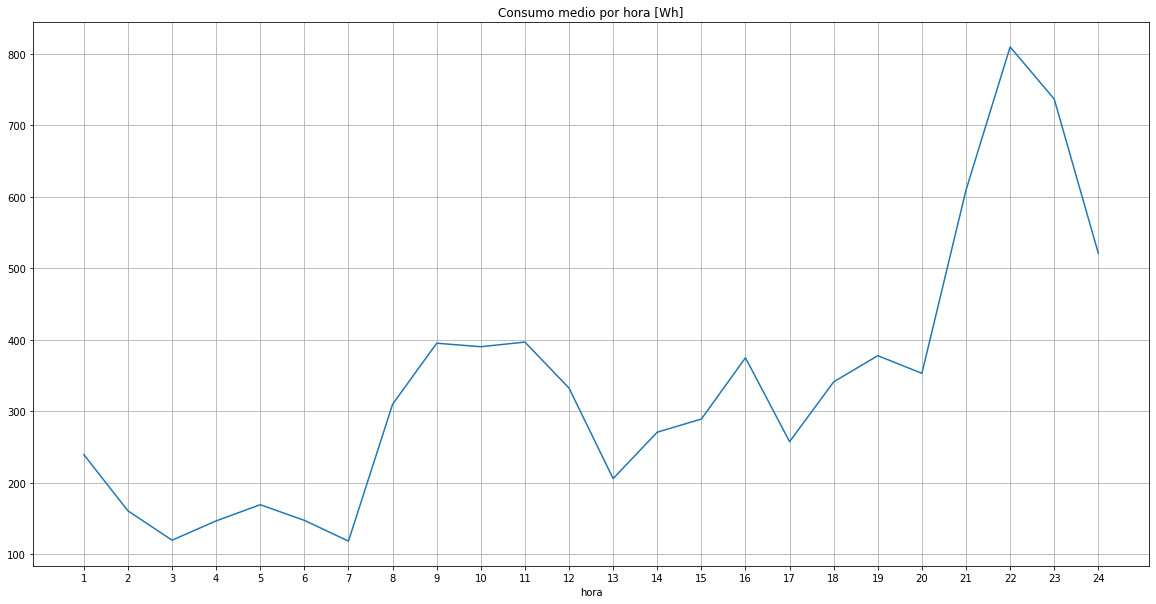

In [116]:
consumo_medio_hora.plot( 
    title='Consumo medio por hora [Wh]', 
    grid=True, kind="line", figsize=(20,10),
    xticks=[x for x in range(1, 25)])
#plt.plot(consumo_medio_hora.index, consumo_medio_hora.values)

## Cálculo de la producción de la instalación

Usamos la librería `pvlib` para relizar los cálculos. Se conecta con el sitio [web europeo de fotovoltáica](https://re.jrc.ec.europa.eu/pvg_tools/en/) (European Comission's JRC PHOTOVOLTAIC GEOGRAPHICAL INFORMATION SYSTEM) para obtener los datos. Ver también el proyecto [Solar Power](https://power.larc.nasa.gov/) de la NASA. El código está tomado del [artículo](https://towardsdatascience.com/solar-panel-power-generation-analysis-7011cc078900) de Leo van der Meulen.

In [117]:
def obtain_panel_power_data(lat, lon, start, end, name, tilt, azimuth, panels, peakpower):
    """
    Determine the solarradiation and generated power for a given solar panel configuration.
    For each hour between startdate and enddate the data is retrieved and calculated.
    :param lat: Latitude of the location
    :param lon: Longitude of the location
    :param start: Startdate for data retrievel
    :param end: Endddate for data retrievel
    :param name: Name of the panel location on the object
    :param tilt: Tilt of the solar panels (0 is flat, 90 is standing straight)
    :param azimuth: Direction the panels, 0 is South, negative from south to east, positive from south to west
    :param panels: Number of panels on the location
    :param peakpower: Peakpower per panel
    :return: dataframe 
    """
    if panels > 0:
        poa, meta, meta2 = pvlib.iotools.get_pvgis_hourly(
            latitude=lat, longitude=lon, start=start, end=end,
            surface_tilt=tilt, surface_azimuth=-azimuth,
            pvcalculation=True, peakpower=peakpower*panels,
            components=True, raddatabase='PVGIS-SARAH2', url='https://re.jrc.ec.europa.eu/api/v5_2/',
            )
    else:
        poa, meta, meta2 = pvlib.iotools.get_pvgis_hourly(
            latitude=lat, longitude=lon, start=start, end=end,
            surface_tilt=tilt, surface_azimuth=-azimuth,
            pvcalculation=False,
            components=True, raddatabase='PVGIS-SARAH2', url='https://re.jrc.ec.europa.eu/api/v5_2/',
            )
        poa['P'] = 0.0
    poa['date'] = pd.to_datetime(poa.index.date)
    poa['location'] = name
    poa['P'] = poa['P'].div(1000)    # change unit to kWh
    print(meta)
    print(meta2)
    return poa

In [118]:
# calculamos la generación.
data_panel_power=obtain_panel_power_data(lat, lon, start, end, name, tilt, azimut, panels, peakpower)

{'location': {'latitude': 38.908688333675734, 'longitude': 1.4240844998325475, 'elevation': 13.0}, 'meteo_data': {'radiation_db': 'PVGIS-SARAH2', 'meteo_db': 'ERA-Interim', 'year_min': 2020, 'year_max': 2020, 'use_horizon': True, 'horizon_db': None, 'horizon_data': 'DEM-calculated'}, 'mounting_system': {'fixed': {'slope': {'value': 30, 'optimal': False}, 'azimuth': {'value': 5, 'optimal': False}, 'type': 'free-standing'}}, 'pv_module': {'technology': 'c-Si', 'peak_power': 1.62, 'system_loss': 0.0}}
{'inputs': {'location': {'description': 'Selected location', 'variables': {'latitude': {'description': 'Latitude', 'units': 'decimal degree'}, 'longitude': {'description': 'Longitude', 'units': 'decimal degree'}, 'elevation': {'description': 'Elevation', 'units': 'm'}}}, 'meteo_data': {'description': 'Sources of meteorological data', 'variables': {'radiation_db': {'description': 'Solar radiation database'}, 'meteo_db': {'description': 'Database used for meteorological variables other than so

In [119]:
#for col in data_panel_power.columns:
#  print(col)

print(f"La radiación ha sido registrada en horario {data_panel_power.index.tz}, pasando a {zona_horaria}")

# el index es la fecha y hora en UTC, creamos una columna en CET para ajustar la hora
data_panel_power['timestamp_ajustado']=data_panel_power.index.tz_convert(CET)

# extraemos la hora y le sumamos 1 para hacerla compatible con el dataset de la compañía
data_panel_power['hora']=data_panel_power.timestamp_ajustado.dt.hour+1

# print(data_panel_power.head(10))

# seleccionamos las columnas de interés
pot_generada=data_panel_power[["date","hora", "P"]]

# seleccionamos el periodo
pot_generada_periodo=pot_generada[pot_generada['date']>=str_start]
pot_generada_periodo=pot_generada_periodo[pot_generada_periodo['date']<=str_fins]

#print(f'\nProducción media por hora [kWh] desde {str_start} hasta {str_fins}')
produccion_media_hora=pot_generada_periodo.groupby(["hora"])['P'].mean()*1000

#produccion_media_hora['produccion']=list(consumo_medio_hora.values)


#lista_datos=[pd.Series(produccion_media_hora.values, index=cols), pd.Series(consumo_medio_hora.values, index=cols)]
comparativa=pd.DataFrame(columns=['produccion', 'consumo'])#, 'diferencia'])

comparativa.produccion=produccion_media_hora.values
comparativa.consumo=consumo_medio_hora.values
#comparativa.diferencia=produccion_media_hora.values-consumo_medio_hora.values

#print(comparativa.head(28))



La radiación ha sido registrada en horario UTC, pasando a Europe/Madrid


## Gráfica de producción y consumo

Consumo medio/dia: 8.040 kWh


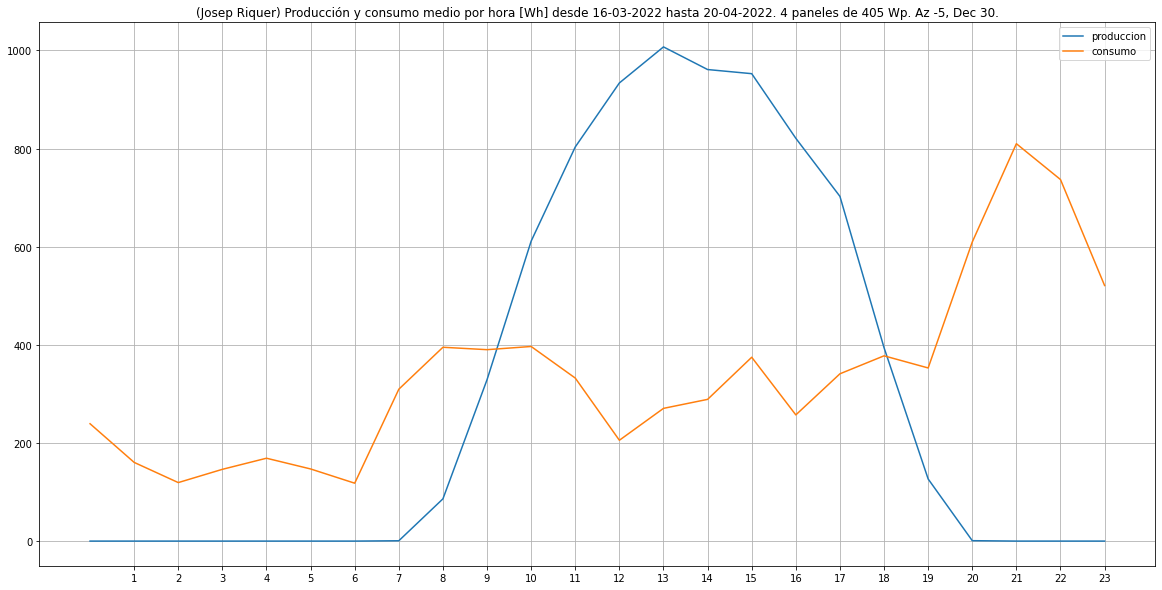

In [120]:
comparativa.plot(
    title=f'({name}) Producción y consumo medio por hora [Wh] desde {desde:%d-%m-%Y} hasta {fins:%d-%m-%Y}. {panels} paneles de {peakpower*1000:.0f} Wp. Az {azimut}, Dec {tilt}.', 
    grid=True, kind="line", figsize=(20,10),
    xticks=[x for x in range(1, 24)]
)

print(f'Consumo medio/dia: {(total_consumo/1000)/dias:.3f} kWh')

## Recursos


PVGIS Photovoltaic Geographical Information System

> European Commission. [PVGIS](https://joint-research-centre.ec.europa.eu/pvgis-photovoltaic-geographical-information-system_en)


Librería pvlib
> William F. Holmgren, Clifford W. Hansen, and Mark A. Mikofski. “pvlib python: a python package for modeling solar energy systems.” Journal of Open Source Software, 3(29), 884, (2018). https://doi.org/10.21105/joss.00884

The power project

> NASA. [https://power.larc.nasa.gov/](https://power.larc.nasa.gov/)

Solar panel power generation analysis

> Leo van der Meulen. "How much energy will you be able to generate with your solar panels? Make your own calculations to stay in control" Medium. [https://towardsdatascience.com/solar-panel-power-generation-analysis-7011cc078900](https://towardsdatascience.com/solar-panel-power-generation-analysis-7011cc078900)

Shadow Calculator

> KameoCode. "Sun position calculator on google maps.
Predict size of shadows at different times of the day for google maps location." [http://shadowcalculator.eu/](http://shadowcalculator.eu/)